In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [139]:
df_repeats, df_calls = file_io.dfs_from_vcf(
    filename="../../data/banana/variants/v0.9.0/SAMEA5752290_merged.vcf", 
    samples=["SAMEA5752290"], 
    vcf_format="ConSTRain"
)

subset = ["genotype", "frequencies"]

df_calls = df_calls.dropna(subset=subset).assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    depth_norm = lambda x: x["depth"] / x["copy_number"],
    n_distinct = lambda x: [len(set(i)) for i in x["genotype"]]
).reset_index(drop=True)

df_calls = df_calls.merge(df_repeats[["str_id", "chr", "start", "end", "period"]], on="str_id")

df_repeats.shape, df_calls.shape

((183345, 7), (153167, 12))

In [140]:
df_chr02 = df_calls.query("chr == 'chr02'").reset_index(drop=True)
df_chr02.shape

(11536, 12)

In [179]:
df_chr02

,sample,str_id,copy_number,frequencies,genotype,depth,depth_norm,n_distinct,chr,start,end,period
0,SAMEA5752290,chr02_27625,3,"{4: 1, 5: 3, 6: 11, 7: 15, 8: 1}","[6, 7, 7]",31,10.333333,2,chr02,27625,27652,2
1,SAMEA5752290,chr02_29033,3,{3: 95},"[3, 3, 3]",95,31.666667,1,chr02,29033,29044,4
2,SAMEA5752290,chr02_32268,3,{3: 57},"[3, 3, 3]",57,19.000000,1,chr02,32268,32279,4
3,SAMEA5752290,chr02_32566,3,{3: 55},"[3, 3, 3]",55,18.333333,1,chr02,32566,32577,4
4,SAMEA5752290,chr02_47952,3,{4: 63},"[4, 4, 4]",63,21.000000,1,chr02,47952,47975,6
...,...,...,...,...,...,...,...,...,...,...,...,...
11531,SAMEA5752290,chr02_34763705,3,"{6: 1, 7: 68}","[7, 7, 7]",69,23.000000,1,chr02,34763705,34763742,2
11532,SAMEA5752290,chr02_34766352,3,"{0: 1, 18: 1, 19: 4, 20: 24, 21: 3, 22: 2, 25: 1}","[19, 20, 20]",36,12.000000,2,chr02,34766352,34766377,1
11533,SAMEA5752290,chr02_34766907,3,"{12: 45, 13: 22, 14: 2}","[12, 12, 13]",69,23.000000,2,chr02,34766907,34766919,1
11534,SAMEA5752290,chr02_34774093,3,"{12: 33, 14: 2, 15: 1, 16: 1, 17: 2, 18: 8, 19...","[12, 12, 18]",49,16.333333,2,chr02,34774093,34774104,1


In [189]:
binsize = 2.5e5
cnv_lower, cnv_upper = 2.8e7, 3.375e7
print(cnv_upper - cnv_lower)
df_chr02.query(f"start >= {cnv_lower} and end <= {cnv_upper}").shape

5750000.0


(2703, 12)

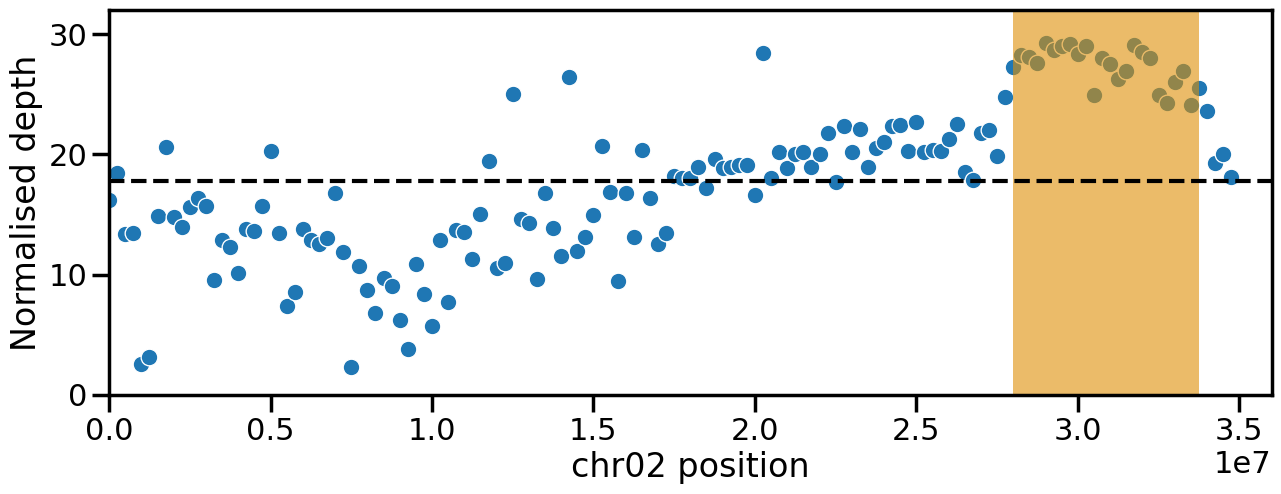

In [187]:
fig = plt.figure(figsize=(15, 5))


df_plot = (df_chr02
     .assign(bin = lambda x: x["start"] // binsize)[["bin", "depth_norm"]]
     .groupby("bin", as_index=False)
     .agg("mean")
     .assign(position = lambda x: x["bin"] * binsize))

ax = sns.scatterplot(
    df_plot,
    x="position",
    y="depth_norm"
)

ax.hlines(
    y = df_plot["depth_norm"].mean(),
    xmin = 0,
    xmax = ax.get_xlim()[1],
    color = "black",
    linestyle = "--"
)

ax.fill_between(
    [cnv_lower, cnv_upper], 
    ax.get_ylim()[0] - 50, 
    ax.get_ylim()[1] + 50, 
    color=sns.color_palette("colorblind")[1], 
    alpha=0.6, 
    linewidth=0
)

_ = ax.set(
    xlabel="chr02 position",
    ylabel="Normalised depth",
    xlim=(0, 3.6e7),
    ylim=(0, 32)
)

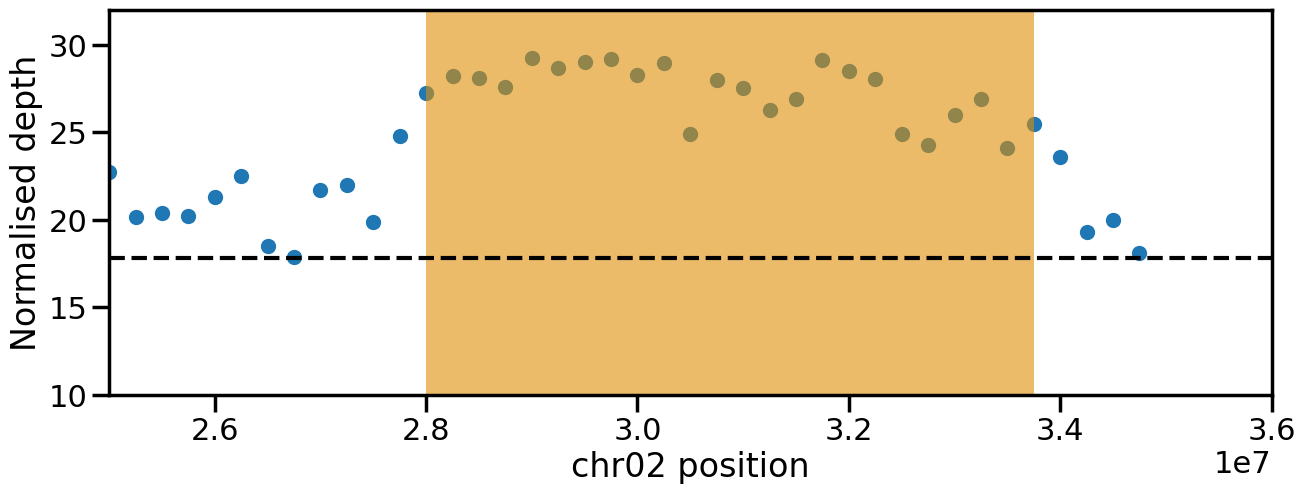

In [186]:
fig = plt.figure(figsize=(15, 5))

df_plot = (df_chr02
     .assign(bin = lambda x: x["start"] // binsize)[["bin", "depth_norm"]]
     .groupby("bin", as_index=False)
     .agg("mean")
     .assign(position = lambda x: x["bin"] * binsize))

ax = sns.scatterplot(
    df_plot,
    x="position",
    y="depth_norm"
)

ax.hlines(
    y = df_plot["depth_norm"].mean(),
    xmin = 0,
    xmax = ax.get_xlim()[1],
    color = "black",
    linestyle = "--"
)

ax.fill_between(
    [cnv_lower, cnv_upper], 
    ax.get_ylim()[0] - 50, 
    ax.get_ylim()[1] + 50, 
    color=sns.color_palette("colorblind")[1], 
    alpha=0.6, 
    linewidth=0
)

_ = ax.set(
    xlabel="chr02 position",
    ylabel="Normalised depth",
    xlim=(2.5e7, 3.6e7),
    ylim=(10, 32)
)

In [170]:
df_repeats, df_calls_dup = file_io.dfs_from_vcf(
    filename="../../data/banana/variants/v0.9.1/SAMEA5752290_merged_chr2_dup.vcf", 
    samples=["SAMEA5752290"], 
    vcf_format="ConSTRain"
)

subset = ["genotype", "frequencies"]

df_calls_dup = df_calls_dup.dropna(subset=subset).assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    depth_norm = lambda x: x["depth"] / x["copy_number"],
    n_distinct = lambda x: [len(set(i)) for i in x["genotype"]]
).reset_index(drop=True)

df_calls_dup = df_calls_dup.merge(df_repeats[["str_id", "chr", "start", "end", "period"]], on="str_id")

df_repeats.shape, df_calls_dup.shape

((183345, 7), (153163, 12))

In [171]:
df_chr02_dup = df_calls_dup.query("chr == 'chr02'").reset_index(drop=True)
df_chr02_dup.shape

(11532, 12)

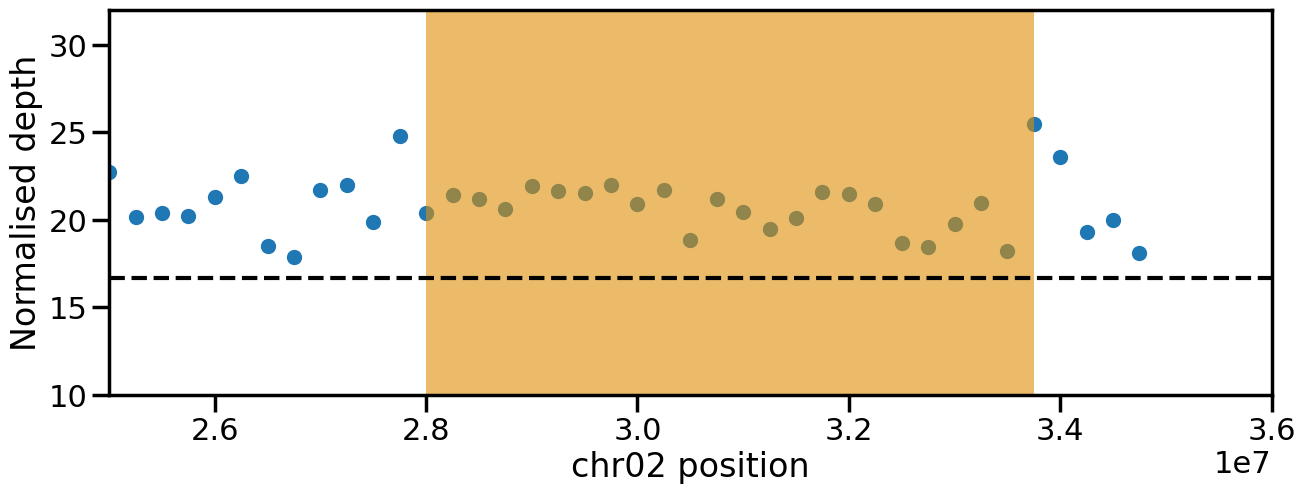

In [188]:
fig = plt.figure(figsize=(15, 5))

df_plot = (df_chr02_dup
     .assign(bin = lambda x: x["start"] // binsize)[["bin", "depth_norm"]]
     .groupby("bin", as_index=False)
     .agg("mean")
     .assign(position = lambda x: x["bin"] * binsize))

ax = sns.scatterplot(
    df_plot,
    x="position",
    y="depth_norm"
)

ax.hlines(
    y = df_plot["depth_norm"].mean(),
    xmin = 0,
    xmax = ax.get_xlim()[1],
    color = "black",
    linestyle = "--"
)

ax.fill_between(
    [cnv_lower, cnv_upper], 
    ax.get_ylim()[0] - 50, 
    ax.get_ylim()[1] + 50, 
    color=sns.color_palette("colorblind")[1], 
    alpha=0.6, 
    linewidth=0
)

_ = ax.set(
    xlabel="chr02 position",
    ylabel="Normalised depth",
    xlim=(2.5e7, 3.6e7),
    ylim=(10, 32)
)